<a href="https://colab.research.google.com/github/tintenderete/TFM-Algoritmo-con-redes-evolutivas/blob/main/revision_evolutivo2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import keras
import tensorflow as tf

from tensorflow.keras.layers import ConvLSTM1D, Dense, Conv2D, LSTM, GRU, Reshape
from tensorflow.keras.layers import ConvLSTM2D, Conv3D, TimeDistributed, Flatten


from keras.callbacks import EarlyStopping
from tensorflow.keras import initializers

In [2]:

# Parámetros
num_dias = 10
num_periodos = 60
num_activos = 5
num_canales = 1

# Crear datos aleatorios para X
X = np.random.uniform(low=-1, high=1, size=(num_dias, num_periodos, num_activos, num_canales))

# Aplicar las transformaciones a los activos 1 y 2
X[:, :, 0, 0] *= 2  # Multiplicar los precios del canal 1 del activo 1 por 2
X[:, :, 1, 0] /= 2  # Dividir los precios del canal 1 del activo 2 entre 2

# Crear la etiqueta Y como el cumsum del canal 1
Y = np.sum(X[:, :, :, 0], axis=1)


In [3]:
X.shape, Y.shape

((10, 60, 5, 1), (10, 5))

# Funcion listas

In [4]:
def get_ranking(Y):
  Y_ranking = np.zeros_like(Y, dtype=int)

  for i in range(Y.shape[0]):
      Y_ranking[i] = np.argsort(np.argsort(-Y[i]))

  return Y_ranking

def get_ranking_tf(Y):
  Y_argsort = tf.argsort(Y, direction='DESCENDING')
  Y_ranking = tf.argsort(Y_argsort)
  return Y_ranking


In [5]:
Y[0:4],get_ranking(Y[0:4])

(array([[ 9.63333229,  0.0276576 ,  2.21118555, -6.3569307 ,  4.727695  ],
        [18.31635636, -0.78203945, -2.80401683,  1.58716242, -1.31192995],
        [10.17058691, -2.20799593,  0.33471638, -1.69880415,  1.20910771],
        [-2.59124797, -0.0738568 ,  8.38390375, -1.22339551, -3.26808634]]),
 array([[0, 3, 2, 4, 1],
        [0, 2, 4, 1, 3],
        [0, 4, 2, 3, 1],
        [3, 1, 0, 2, 4]]))

In [6]:
Y = get_ranking(Y)

In [7]:
Y[0:4]

array([[0, 3, 2, 4, 1],
       [0, 2, 4, 1, 3],
       [0, 4, 2, 3, 1],
       [3, 1, 0, 2, 4]])

In [8]:
get_ranking(Y)

array([[4, 1, 2, 0, 3],
       [4, 2, 0, 3, 1],
       [4, 0, 2, 1, 3],
       [1, 3, 4, 2, 0],
       [4, 2, 3, 0, 1],
       [0, 3, 1, 4, 2],
       [4, 2, 3, 1, 0],
       [4, 0, 3, 2, 1],
       [1, 2, 0, 4, 3],
       [4, 2, 0, 1, 3]])

In [9]:
get_ranking_tf(Y)

<tf.Tensor: shape=(10, 5), dtype=int32, numpy=
array([[4, 1, 2, 0, 3],
       [4, 2, 0, 3, 1],
       [4, 0, 2, 1, 3],
       [1, 3, 4, 2, 0],
       [4, 2, 3, 0, 1],
       [0, 3, 1, 4, 2],
       [4, 2, 3, 1, 0],
       [4, 0, 3, 2, 1],
       [1, 2, 0, 4, 3],
       [4, 2, 0, 1, 3]], dtype=int32)>

# GeneticAlgorithm

In [10]:
class GeneticAlgorithm:
    def __init__(self,
                 initial_population,
                 fitness_function,
                 selection_function,
                 crossover_function,
                 mutation_function,
                 immigration_function,
                 n_generations,
                 n_save_best_population):
        self.population = initial_population
        self.fitness_function = fitness_function
        self.selection_function = selection_function
        self.crossover_function = crossover_function
        self.mutation_function = mutation_function
        self.immigration_function = immigration_function
        self.n_generations = n_generations
        self.n_save_best_population = n_save_best_population

    def run(self):
        for i in range(self.n_generations):
            fitness = self.fitness_function(self.population)
            best_population = self._get_best_population(self.population,  fitness)
            parents = self.selection_function(self.population, fitness)
            offspring = self.crossover_function(parents)
            offspring = self.mutation_function(offspring)
            self.population = np.concatenate((parents, offspring))

            immigration = self.immigration_function()
            self.population = np.concatenate((self.population, immigration))

            if(len(best_population)>0):
              self.population = np.concatenate((self.population, best_population))


            # STATS

            print("GENERATION: " + str(i))
            print("Fitness: ")
            print(fitness)

        # Devuelve la mejor solución encontrada
        fitness = self.fitness_function(self.population)
        best_idx = np.argmax(fitness)
        return self.population[best_idx]

    def _get_best_population(self,population,  fitness):
      idx_best_pop = np.argsort(fitness)[::1][:self.n_save_best_population]

      return np.array(population)[idx_best_pop]


In [11]:
pop = [[1,1],[2,2],[10,10],[11,11],[20,20],[30,30],[40,40] ]
fitness = np.array([1,2,10,11, 20,0,40])

In [12]:
geneticAlgorithm = GeneticAlgorithm(1,2,3,4,5,6,7,n_save_best_population = 3)

In [13]:
geneticAlgorithm._get_best_population(pop,fitness)

array([[30, 30],
       [ 1,  1],
       [ 2,  2]])

# cost function

In [14]:
# TIENE ERRORES QUE FIXEAR
def loss_ranking(ranking_real, ranking_predicho):

    ranking_real_float = tf.cast(ranking_real, tf.float32)
    ranking_predicho = get_ranking_tf(-ranking_predicho) # <<<<---------
    ranking_predicho = tf.cast(ranking_predicho, tf.float32)
    diferencias = tf.abs(ranking_real_float - ranking_predicho)
    diferencias_ponderadas = diferencias / (ranking_predicho + 0.01) # <<<<---------
    perdida_total = tf.reduce_sum(diferencias_ponderadas)
    return abs(perdida_total)

In [15]:
def loss_ranking(y_true, y_pred, weights = 1):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    diff = tf.abs(y_true - y_pred)
    loss = tf.reduce_mean(weights * diff)
    return loss


In [16]:
def loss_ranking(ranking_real, ranking_predicho):
    ranking_real_float = tf.cast(ranking_real, tf.float32)
    ranking_predicho = tf.cast(ranking_predicho, tf.float32)
    diferencias = tf.abs(ranking_real_float - ranking_predicho)
    diferencias_ponderadas = diferencias / (ranking_predicho + 0.01) # <<<<---------
    perdida_total = tf.reduce_sum(diferencias_ponderadas)
    return abs(perdida_total)

In [17]:
ranking_real = np.array([0,1,2])
ranking_predicho = np.array([1,2,0])

In [18]:
ranking_real_float = tf.cast(ranking_real, tf.float32)
ranking_real_float

<tf.Tensor: shape=(3,), dtype=float32, numpy=array([0., 1., 2.], dtype=float32)>

In [19]:
ranking_predicho = get_ranking_tf(-ranking_predicho)
ranking_predicho

<tf.Tensor: shape=(3,), dtype=int32, numpy=array([1, 2, 0], dtype=int32)>

In [20]:
ranking_predicho = tf.cast(ranking_predicho, tf.float32)
ranking_predicho

<tf.Tensor: shape=(3,), dtype=float32, numpy=array([1., 2., 0.], dtype=float32)>

In [21]:
diferencias = tf.abs(ranking_real_float - ranking_predicho)
diferencias

<tf.Tensor: shape=(3,), dtype=float32, numpy=array([1., 1., 2.], dtype=float32)>

In [22]:
ranking_predicho + 0.01

<tf.Tensor: shape=(3,), dtype=float32, numpy=array([1.01, 2.01, 0.01], dtype=float32)>

In [23]:
diferencias_ponderadas = diferencias / (ranking_predicho + 0.01)
diferencias_ponderadas

<tf.Tensor: shape=(3,), dtype=float32, numpy=array([  0.990099  ,   0.49751243, 200.        ], dtype=float32)>

In [24]:
perdida_total = tf.reduce_sum(diferencias_ponderadas)
perdida_total

<tf.Tensor: shape=(), dtype=float32, numpy=201.48761>

In [25]:
loss_ranking(np.array([0,1,2]), np.array([0,1,2]))

<tf.Tensor: shape=(), dtype=float32, numpy=0.0>

In [26]:
loss_ranking(np.array([0,1,2]), np.array([3,1,2]))

<tf.Tensor: shape=(), dtype=float32, numpy=0.99667776>

In [27]:
loss_ranking(np.array([1,2,3]), np.array([1,2,3]))

<tf.Tensor: shape=(), dtype=float32, numpy=0.0>

In [28]:
loss_ranking(np.array([1,2,3]), np.array([1,2,3]))

<tf.Tensor: shape=(), dtype=float32, numpy=0.0>

In [29]:
loss_ranking(np.array([1,2,3]), np.array([8,2,3]))

<tf.Tensor: shape=(), dtype=float32, numpy=0.87390757>

In [30]:
loss_ranking(np.array([1,2,3]), np.array([1,2,3+5]))

<tf.Tensor: shape=(), dtype=float32, numpy=0.6242197>

In [31]:
loss_ranking(np.array([1,2,3]), np.array([1,2,3-5]))

<tf.Tensor: shape=(), dtype=float32, numpy=2.5125628>

In [32]:
loss_ranking(np.array([1,2,3]), np.array([5,2,-8]))

<tf.Tensor: shape=(), dtype=float32, numpy=0.57831776>

# REVISAR AQUI , ESTA BIEN ORDENADO PERO ESTA FUNCIONDE COSTA CASTIGA FUERTE

In [33]:
loss_ranking(np.array([1,2,3]), np.array([-2,-5,-8]))

<tf.Tensor: shape=(), dtype=float32, numpy=4.2870646>

# initial_population

## gen_individual

In [34]:
ind_A = [
    # numero_de_layers_densas1
    # numero_de_units1
    # activation1
    # numero_de_layers_densas2
    # numero_de_units2
    # activation2
    # numero_de_layers_densas3
    # numero_de_units3
    # activation3
    # output_activation
]

def get_ind_A():
  ind_A = [
      np.random.randint(0,5),
      np.random.randint(1,10) * 10 - 9,
      np.random.choice(['relu','linear']),
      np.random.randint(0,5),
      np.random.randint(1,10) * 10 - 9,
      np.random.choice(['relu','linear']),
      np.random.randint(0,5),
      np.random.randint(1,10) * 10 - 9,
      np.random.choice(['relu','linear']),
      np.random.choice(['linear', 'relu','softplus', 'softmax'])
      #np.random.choice(['softmax'])
  ]
  return ind_A

In [35]:
for i in range(10):
  print(get_ind_A())

[4, 31, 'linear', 1, 61, 'linear', 3, 81, 'linear', 'softplus']
[2, 11, 'linear', 3, 31, 'linear', 4, 71, 'linear', 'linear']
[3, 61, 'relu', 2, 21, 'relu', 2, 1, 'relu', 'softplus']
[1, 51, 'relu', 1, 11, 'linear', 4, 51, 'linear', 'relu']
[3, 21, 'relu', 3, 41, 'relu', 2, 21, 'linear', 'linear']
[2, 51, 'linear', 1, 1, 'linear', 1, 61, 'linear', 'relu']
[0, 81, 'relu', 1, 71, 'relu', 1, 31, 'linear', 'relu']
[3, 11, 'linear', 1, 71, 'relu', 1, 81, 'relu', 'linear']
[2, 81, 'relu', 1, 81, 'relu', 4, 81, 'relu', 'linear']
[2, 21, 'relu', 2, 71, 'relu', 0, 71, 'relu', 'linear']


## gen_population

In [36]:
def gen_population(n_pop = 50):
  pop = []
  for p in range(n_pop):
    pop.append(get_ind_A())
  return np.array(pop, dtype=object)

In [37]:
gen_population(n_pop = 3)

array([[0, 71, 'linear', 3, 21, 'linear', 1, 11, 'linear', 'linear'],
       [1, 31, 'relu', 0, 11, 'linear', 3, 21, 'relu', 'relu'],
       [3, 1, 'relu', 0, 21, 'relu', 1, 71, 'linear', 'softmax']],
      dtype=object)

## create_model

In [38]:
def create_model(iput_shape, output_shape, ind_gens, learning_rate=0.001):

  numero_de_layers_densas1 = ind_gens[0]
  numero_de_units1= ind_gens[1]
  activation1= ind_gens[2]
  numero_de_layers_densas2= ind_gens[3]
  numero_de_units2 = ind_gens[4]
  activation2= ind_gens[5]
  numero_de_layers_densas3= ind_gens[6]
  numero_de_units3 = ind_gens[7]
  activation3= ind_gens[8]
  output_activation = ind_gens[9]

  inputs = keras.Input(shape=(iput_shape))
  m = inputs


  for i in range(numero_de_layers_densas1):
    m = Dense( units=numero_de_units1 , activation=activation1,
    #kernel_initializer=initializers.RandomNormal(stddev=0.01)
    )(m)


  for i in range(numero_de_layers_densas2):
    m = Dense( units=numero_de_units2 , activation=activation2,
    #kernel_initializer=initializers.RandomNormal(stddev=0.01)
    )(m)


  for i in range(numero_de_layers_densas3):
    m = Dense( units=numero_de_units3 , activation=activation3,
    #kernel_initializer=initializers.RandomNormal(stddev=0.01)
    )(m)

  m = Flatten()(m)
  outputs = Dense(output_shape, activation = output_activation,
    #kernel_initializer=initializers.RandomNormal(stddev=0.01)
    )(m)
  model = keras.Model(inputs=inputs, outputs=outputs)
  model.compile(
      loss=loss_ranking,
      optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
      metrics=[],
    )

  return model


In [39]:
create_model(iput_shape = (35, 3), output_shape =  (35), ind_gens = get_ind_A()).summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 35, 3)]           0         
                                                                 
 dense (Dense)               (None, 35, 41)            164       
                                                                 
 dense_1 (Dense)             (None, 35, 41)            1722      
                                                                 
 dense_2 (Dense)             (None, 35, 41)            1722      
                                                                 
 dense_3 (Dense)             (None, 35, 41)            1722      
                                                                 
 dense_4 (Dense)             (None, 35, 41)            1722      
                                                                 
 dense_5 (Dense)             (None, 35, 41)            1722  

## mse

In [40]:
Y.shape

(10, 5)

In [41]:
tf.keras.metrics.mean_squared_error(
    Y[0], Y[0]
)

<tf.Tensor: shape=(), dtype=int64, numpy=0>

In [42]:
tf.keras.metrics.mean_squared_error(
    [4,5], [4,5]
)

<tf.Tensor: shape=(), dtype=int32, numpy=0>

In [43]:
tf.keras.metrics.mean_squared_error(
    [4,5], [17,4]
)

<tf.Tensor: shape=(), dtype=int32, numpy=85>

In [44]:
tf.keras.metrics.mean_squared_error(
    [4,5], [-17,4]
)

<tf.Tensor: shape=(), dtype=int32, numpy=221>

## model_population

In [45]:
def model_population(iput_shape, output_shape,populations_gens, learning_rate):
  pop = []
  for i in range(len(populations_gens)):

    pop.append( create_model(iput_shape, output_shape, populations_gens[i], learning_rate) )

  return pop


In [46]:
pop = [[3, 100, 'linear', 3, 120, 'relu', 3, 120, 'relu', 'relu'],
 [7, 80, 'relu', 6, 160, 'linear', 3, 120, 'relu', 'relu'],
 [4, 100, 'relu', 3, 100, 'linear', 3, 120, 'relu', 'relu']]

In [47]:
models_pop = model_population((35,3), (35),pop, 0.01)

In [48]:
models_pop

In [49]:
for m in models_pop:
  print(m.summary())

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 35, 3)]           0         
                                                                 
 dense_9 (Dense)             (None, 35, 100)           400       
                                                                 
 dense_10 (Dense)            (None, 35, 100)           10100     
                                                                 
 dense_11 (Dense)            (None, 35, 100)           10100     
                                                                 
 dense_12 (Dense)            (None, 35, 120)           12120     
                                                                 
 dense_13 (Dense)            (None, 35, 120)           14520     
                                                                 
 dense_14 (Dense)            (None, 35, 120)           1452

# Fitness_function

In [50]:
class Fitness_function_keras():
  def __init__(self, X, Y, epochs, batch_size, learning_rate):
    self.X = X
    self.Y = Y
    self.epochs = epochs
    self.batch_size = batch_size
    self.learning_rate = learning_rate

    self.last_loss_history = []

  def run(self, gens_population ):
    return self.fitness_keras(self.X, self.Y, gens_population , self.epochs, self.batch_size)

  def fitness_keras(self, X, Y, gens_population , epochs, batch_size):

    self.last_loss_history = []

    population_models = model_population(X.shape[1:], Y.shape[1], gens_population, self.learning_rate)

    fitness = []

    for m in population_models:

      h = m.fit(X,Y,
                  epochs=epochs,
                  batch_size = batch_size,
                  verbose=0,
                  callbacks=[EarlyStopping(monitor='loss', patience=10, min_delta=0)])

      self.last_loss_history.append(h.history["loss"])
      # Con este seleccionamos el ultimo loss
      #fitness.append(h.history["loss"][-1])
      # Con este seleccionamos el mejor de los loss
      idx_best_loss = np.argmin(h.history["loss"])
      fitness.append(h.history["loss"][idx_best_loss])

    return np.array(fitness)

In [51]:
Y[0]

array([0, 3, 2, 4, 1])

In [52]:
Y.shape

(10, 5)

In [53]:
pop = [get_ind_A(),
 get_ind_A(),
 get_ind_A()]
print(pop)
fitness_function_keras = Fitness_function_keras(X, Y , epochs = 2, batch_size = 1, learning_rate = 0.1)

fitness = fitness_function_keras.run(pop)
print(fitness)

[[3, 61, 'relu', 4, 51, 'linear', 1, 71, 'linear', 'softmax'], [2, 31, 'linear', 4, 71, 'relu', 3, 11, 'linear', 'linear'], [3, 1, 'linear', 3, 61, 'relu', 1, 41, 'linear', 'relu']]
[771.28710938   5.00000191 542.        ]


# Selection_function

In [54]:
class Selection_function():
  def __init__(self, number_of_couples = 1, tournament_size = 3):
    self.number_of_couples = number_of_couples
    self.tournament_size = tournament_size

  def tournament_selection(self, population, fitness):
    all_parents = []
    for i in range(self.number_of_couples):
      idx = np.random.choice(np.arange(len(population)), size=self.tournament_size, replace=False)
      orden = np.argsort(fitness[idx])
      best_individual_idx = idx[orden[0:2]]
      all_parents.append(population[best_individual_idx[0]])
      all_parents.append(population[best_individual_idx[1]])
    return all_parents


In [55]:
pop = np.array([[3, 100, 'linear', 3, 120, 'relu', 'relu'],
 [7, 80, 'relu', 6, 160, 'linear', 'relu'],
 [4, 100, 'relu', 3, 100, 'linear', 'relu']])
fitness = np.array([28.697153091430664, 28.697154998779297, 28.697158813476562])

selection = Selection_function(number_of_couples = 10)

parents = selection.tournament_selection(pop, fitness)

print( parents )

[array(['3', '100', 'linear', '3', '120', 'relu', 'relu'], dtype='<U21'), array(['7', '80', 'relu', '6', '160', 'linear', 'relu'], dtype='<U21'), array(['3', '100', 'linear', '3', '120', 'relu', 'relu'], dtype='<U21'), array(['7', '80', 'relu', '6', '160', 'linear', 'relu'], dtype='<U21'), array(['3', '100', 'linear', '3', '120', 'relu', 'relu'], dtype='<U21'), array(['7', '80', 'relu', '6', '160', 'linear', 'relu'], dtype='<U21'), array(['3', '100', 'linear', '3', '120', 'relu', 'relu'], dtype='<U21'), array(['7', '80', 'relu', '6', '160', 'linear', 'relu'], dtype='<U21'), array(['3', '100', 'linear', '3', '120', 'relu', 'relu'], dtype='<U21'), array(['7', '80', 'relu', '6', '160', 'linear', 'relu'], dtype='<U21'), array(['3', '100', 'linear', '3', '120', 'relu', 'relu'], dtype='<U21'), array(['7', '80', 'relu', '6', '160', 'linear', 'relu'], dtype='<U21'), array(['3', '100', 'linear', '3', '120', 'relu', 'relu'], dtype='<U21'), array(['7', '80', 'relu', '6', '160', 'linear', 'relu'],

In [56]:
# los dos primeros padres
parents[0], parents[1]

(array(['3', '100', 'linear', '3', '120', 'relu', 'relu'], dtype='<U21'),
 array(['7', '80', 'relu', '6', '160', 'linear', 'relu'], dtype='<U21'))

# Crossover_function

In [57]:
def uniform_crossover(parent1, parent2):
    child1, child2 = parent1.copy(), parent2.copy()
    for i in range(len(parent1)):
        if np.random.uniform(0, 1) < 0.5:  # Choose randomly
            child1[i], child2[i] = child2[i], child1[i]  # Swap elements
    return child1, child2

In [58]:
def easy_crossover(parents):
  offspring = []
  for i in range(0, len(parents), 2):

    parent1 = parents[i]
    parent2 = parents[i+1]

    childs = uniform_crossover(parent1, parent2 )

    offspring.append(childs[0])
    offspring.append(childs[1])

  return offspring

In [59]:
ofs = easy_crossover(parents)
print(ofs)

[array(['3', '100', 'relu', '6', '160', 'linear', 'relu'], dtype='<U21'), array(['7', '80', 'linear', '3', '120', 'relu', 'relu'], dtype='<U21'), array(['3', '80', 'relu', '3', '120', 'relu', 'relu'], dtype='<U21'), array(['7', '100', 'linear', '6', '160', 'linear', 'relu'], dtype='<U21'), array(['7', '100', 'linear', '3', '160', 'relu', 'relu'], dtype='<U21'), array(['3', '80', 'relu', '6', '120', 'linear', 'relu'], dtype='<U21'), array(['3', '100', 'relu', '6', '160', 'relu', 'relu'], dtype='<U21'), array(['7', '80', 'linear', '3', '120', 'linear', 'relu'], dtype='<U21'), array(['3', '80', 'relu', '6', '160', 'linear', 'relu'], dtype='<U21'), array(['7', '100', 'linear', '3', '120', 'relu', 'relu'], dtype='<U21'), array(['3', '80', 'linear', '6', '120', 'relu', 'relu'], dtype='<U21'), array(['7', '100', 'relu', '3', '160', 'linear', 'relu'], dtype='<U21'), array(['3', '80', 'relu', '6', '120', 'linear', 'relu'], dtype='<U21'), array(['7', '100', 'linear', '3', '160', 'relu', 'relu'],

In [60]:
# primer hijo
ofs[0]

array(['3', '100', 'relu', '6', '160', 'linear', 'relu'], dtype='<U21')

# mutation_function

In [61]:
def mutation(offspring):
  return offspring

# genetico y funciones TEST

In [62]:
geneticAlgorithm = GeneticAlgorithm(1,2,3,4,5,6,7,n_save_best_population = 10)
initial_population = gen_population(n_pop = 50)
fitness_function_keras = Fitness_function_keras(X, Y , epochs = 100, batch_size = 2, learning_rate = 0.01)
selection = Selection_function(number_of_couples = 10 )
n_immigration_function = 30

In [63]:
#print("---- initial_population ----")
population = initial_population
#print(population)
#print(len(population))

for i in range(4):

  print("||||||| GEN: " + str(i) + " ||||||||")

  #print("---- fitness ----")
  fitness = fitness_function_keras.run(population)
  #print(fitness)
  #print(len(fitness))

  best_idx = np.argmin(fitness)

  best_fitness = fitness[best_idx]
  print("best fitness: " + str(best_fitness))
  print("best_model: ")
  print(population[best_idx])

  if best_fitness < 0.1:
    #print("best_model: " )
    #print(population[best_idx])
    print("ENTRENAMIENTO TERMINADO")
    break

  print("---- best_population ----")
  best_population = geneticAlgorithm._get_best_population(population,fitness)
  print(best_population)
  print(len(best_population))

  #print("---- parents ----")
  parents = selection.tournament_selection(population, fitness)
  #print(parents)
  #print(len(parents))

  print("---- offspring crossover ----")
  offspring = easy_crossover(parents)
  #print(offspring)
  print(len(offspring))

  #print("---- offspring mutation ----")
  offspring = mutation(offspring)
  #print(offspring)
  #print(len(offspring))

  #print("---- population ----")
  population = offspring
  #population = np.concatenate((parents, offspring))
  #print(population)
  #print(len(population))

  print("---- immigration ----")
  immigration = gen_population(n_pop = n_immigration_function)
  #print(immigration)
  print(len(immigration))

  #print("---- population + immigration ----")
  population = np.concatenate((population, immigration))
  #print(population)
  #print(len(population))

  print("---- population + best_population ----")
  population = np.concatenate((population, best_population))
  #print(population)
  print(len(population))



||||||| GEN: 0 ||||||||
best fitness: 2.3168067932128906
best_model: 
[1 21 'linear' 0 1 'linear' 0 51 'linear' 'linear']
---- best_population ----
[[1 21 'linear' 0 1 'linear' 0 51 'linear' 'linear']
 [3 71 'relu' 1 61 'relu' 1 51 'relu' 'softplus']
 [4 11 'linear' 2 71 'linear' 2 11 'relu' 'softplus']
 [1 81 'linear' 0 61 'linear' 3 21 'relu' 'softplus']
 [1 11 'relu' 1 81 'linear' 3 21 'relu' 'softplus']
 [2 61 'relu' 1 11 'linear' 3 41 'relu' 'softplus']
 [2 1 'relu' 1 31 'linear' 0 41 'linear' 'linear']
 [0 41 'linear' 4 21 'relu' 3 11 'relu' 'linear']
 [2 61 'relu' 3 21 'linear' 1 31 'relu' 'linear']
 [1 1 'relu' 2 41 'linear' 0 81 'relu' 'softplus']]
10
---- offspring crossover ----
20
---- immigration ----
30
---- population + best_population ----
60
||||||| GEN: 1 ||||||||
best fitness: 1.0869430303573608
best_model: 
[1 81 'linear' 0 61 'linear' 3 21 'relu' 'softplus']
---- best_population ----
[[1 81 'linear' 0 61 'linear' 3 21 'relu' 'softplus']
 [0 71 'relu' 2 71 'relu' 0 

In [76]:
#bad_gen = initial_population[3]
model_test = create_model(X.shape[1:], Y.shape[1],population[best_idx], learning_rate=0.01)
model_test.summary()

Model: "model_250"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_251 (InputLayer)      [(None, 60, 5, 1)]        0         
                                                                 
 dense_1831 (Dense)          (None, 60, 5, 11)         22        
                                                                 
 dense_1832 (Dense)          (None, 60, 5, 11)         132       
                                                                 
 dense_1833 (Dense)          (None, 60, 5, 11)         132       
                                                                 
 dense_1834 (Dense)          (None, 60, 5, 11)         132       
                                                                 
 dense_1835 (Dense)          (None, 60, 5, 21)         252       
                                                                 
 dense_1836 (Dense)          (None, 60, 5, 21)         46

In [77]:

for i in range(100):
  model_test_h = model_test.fit(X,Y,
                    epochs=100,
                    batch_size = 2,
                    verbose=0)

  idx_best_loss = np.argmin(model_test_h.history["loss"])
  best_loss = model_test_h.history["loss"][idx_best_loss]
  print(i)
  print(best_loss)
  if best_loss < 0.01 : break

  # RESULTADO PRUEBA prints
  #37
  #0.009670293889939785



0
5.845887184143066
1
5.246531963348389
2
5.867151737213135
3
5.805991172790527
4
5.619419097900391
5
5.1954345703125
6
7.834190368652344
7
2.0034101009368896
8
2.0026609897613525
9
2.0023324489593506
10
2.002110719680786
11
2.001936674118042
12
2.0017898082733154
13
2.001659870147705
14
2.0015416145324707
15
2.001431703567505
16
2.001328945159912
17
2.0012311935424805
18
2.001138687133789
19
2.0010507106781006
20
2.0009665489196777
21
2.000887632369995
22
2.0008156299591064
23
2.000746250152588
24
2.000680446624756
25
2.000617504119873
26
2.0005574226379395
27
2.000500202178955
28
2.000445604324341
29
2.0003936290740967
30
2.0003437995910645
31
2.000296115875244
32
2.0002498626708984
33
2.0002057552337646
34
2.000164747238159
35
2.0001285076141357
36
2.0000994205474854
37
2.0000758171081543
38
2.000058174133301
39
2.0000452995300293
40
2.0000357627868652
41
2.000028133392334
42
2.0000226497650146
43
2.0000014305114746
44
2.000000476837158
45
2.000000476837158
46
2.000000476837158
47
2

In [66]:
for i in range(100):
  model_test = create_model(X.shape[1:], Y.shape[1],population[best_idx], learning_rate=0.01)
  model_test_h = model_test.fit(X,Y,
                    epochs=100,
                    batch_size = 2,
                    verbose=0)

  idx_best_loss = np.argmin(model_test_h.history["loss"])
  best_loss = model_test_h.history["loss"][idx_best_loss]
  print(i)
  print(best_loss)
  if best_loss < 0.1 : break

0
0.10171397030353546
1
6.002820014953613
2
10.000110626220703
3
6.576268196105957
4
10.00024127960205
5
4.68679141998291
6
3.6238811016082764
7
10.000328063964844
8
2.409921169281006
9
10.000144958496094
10
10.000826835632324
11
4.6372599601745605
12
1.8564732074737549
13
10.000309944152832
14
6.054340839385986
15
10.00030517578125
16
10.000188827514648
17
10.000195503234863
18
6.786607265472412
19
3.2505462169647217
20
5.396553039550781
21
0.49499255418777466
22
10.000079154968262
23
6.003343105316162
24
10.000059127807617
25
4.90267276763916
26
2.03680157661438
27
10.00020980834961
28
10.0010986328125
29
2.1737072467803955
30
2.003757953643799
31
10.000142097473145
32
7.806699275970459
33
10.000066757202148
34
2.5566842555999756
35
10.000432968139648
36
10.000114440917969
37
10.000166893005371
38
6.001334190368652
39
10.000307083129883
40
5.4362688064575195
41
10.000086784362793
42
5.0392255783081055
43
10.000082015991211
44
10.000356674194336
45
10.00013542175293
46
10.000139236450

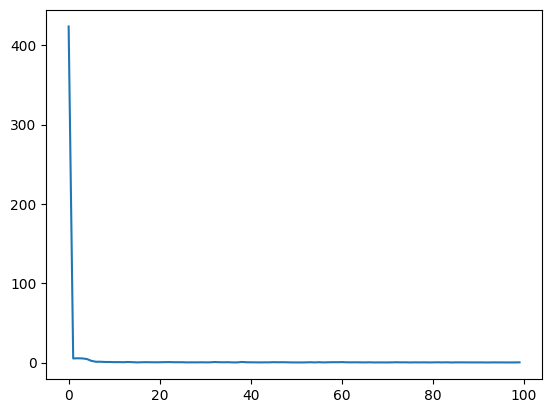

In [67]:
plt.plot(model_test_h.history['loss'])

In [68]:
y_pred = model_test(X)

In [69]:
y_pred

<tf.Tensor: shape=(10, 5), dtype=float32, numpy=
array([[-3.9137735,  2.7946322,  2.8514056,  4.855861 ,  2.8599906],
       [-3.9849377,  2.9737535,  4.0157084,  2.7339706,  3.1841385],
       [-3.8671443,  3.9278564,  2.5202656,  3.6857233,  2.333171 ],
       [-4.5358777,  2.6630263,  3.0057998,  3.3149219,  3.6477933],
       [-3.8209374,  2.5888581,  2.7699099,  4.8815093,  2.9964752],
       [-4.814195 ,  2.6175282,  2.7349558,  3.5890512,  3.0529838],
       [-3.9237278,  2.2597427,  2.2471662,  4.329542 ,  3.5362449],
       [-3.9970655,  3.6106453,  2.5917776,  2.8991737,  2.9181058],
       [-3.827363 ,  2.9523704,  3.7083573,  3.7497153,  2.6679723],
       [-3.961441 ,  2.83394  ,  3.9831655,  3.80653  ,  2.560509 ]],
      dtype=float32)>

In [70]:
get_ranking(-y_pred)

array([[0, 1, 2, 4, 3],
       [0, 2, 4, 1, 3],
       [0, 4, 2, 3, 1],
       [0, 1, 2, 3, 4],
       [0, 1, 2, 4, 3],
       [0, 1, 2, 4, 3],
       [0, 2, 1, 4, 3],
       [0, 4, 1, 2, 3],
       [0, 2, 3, 4, 1],
       [0, 2, 4, 3, 1]])

In [71]:
Y

array([[0, 3, 2, 4, 1],
       [0, 2, 4, 1, 3],
       [0, 4, 2, 3, 1],
       [3, 1, 0, 2, 4],
       [0, 2, 1, 4, 3],
       [4, 1, 3, 0, 2],
       [0, 2, 1, 3, 4],
       [0, 4, 1, 2, 3],
       [3, 2, 4, 0, 1],
       [0, 2, 4, 3, 1]])

In [72]:
loss_ranking(Y, get_ranking(-y_pred))

<tf.Tensor: shape=(), dtype=float32, numpy=1009.1981>